In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import joblib
import datetime as dt

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.models as models

#from skimage import io
import sklearn
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix, classification_report
from sklearn import metrics, preprocessing
from scipy.ndimage import zoom
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import albumentations as A
import albumentations.pytorch
import wandb

#### Hyper Param Setting

In [2]:
CFG = {
    'fold_num': 5,
    'seed': 42,
    't_model': 'resnet152',
    'load_model': 'KD_resnet152_dishes_202305200035', # LOAD TEACHER MODEL
    's_model': 'mobilenet_v3_large',
    'img_size': 260,
    'alpha': 0.5, # HARD LABEL : SOFT LABEL RATIO
    'epochs': 200, 
    'train_bs':64,
    'valid_bs':64,
    'lr': 1e-4, ## learning rate
    'num_workers': 8,
    'verbose_step': 1,
    'patience' : 5,
    'label_encoder':False,
    'device': 'cuda:0',
    'freezing': False,
    'trainable_layer': 6,
    'model_path': './models'
}

#### wandb init

In [3]:
category = 'dishes'
time_now = dt.datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M")
project_name = 'KD_'+ category + '_'+ CFG['t_model'] + '_' + CFG['s_model']
user = 'hojunking'
run_name = project_name + '_' + run_id

In [4]:
# TRAIN DATASET DATAFRAME
train_path = '../Data/carbon_reduction_data/train/'
label_list = ['wrap','leftover','green dish']

train_img_paths = []
train_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}',end=' ')
    img_paths = [] 
    img_labels = []

    dir_path = train_path + label ## 레이블 폴더 경로
    
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
        for img in filenames: ## 각 파일 경로, 레이블 저장
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
    print(len(img_paths))

    train_img_paths.extend(img_paths)
    train_img_labels.extend(img_labels)

print('Train_Images: ',len(train_img_paths))
print("Train_Images_labels:", len(train_img_labels))

label: wrap 1266
label: leftover 1483
label: green dish 1261
Train_Images:  4010
Train_Images_labels: 4010


In [5]:
# TEST DATASET DATAFRAME
test_path =  '../Data/carbon_reduction_data/test/'
test_img_paths = []
test_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}',end=' ')
    img_paths = [] 
    img_labels = []
    dir_path = test_path + label ## 레이블 폴더 경로
    
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
        for img in filenames: ## 각 파일 경로, 레이블 저장
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
    print(len(img_paths))

    test_img_paths.extend(img_paths)
    test_img_labels.extend(img_labels)

print('Test_Images: ',len(test_img_paths))
print("Test_Images_labels:", len(test_img_labels))

label: wrap 423
label: leftover 495
label: green dish 421
Test_Images:  1339
Test_Images_labels: 1339


In [6]:
## Pandas 데이터프레임 만들기
trn_df = pd.DataFrame(train_img_paths, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = train_img_labels
train = trn_df
train

,image_id,dir,label
0,0720.jpg,../Data/carbon_reduction_data/train/wrap,wrap
1,0282.jpg,../Data/carbon_reduction_data/train/wrap,wrap
2,1028.jpg,../Data/carbon_reduction_data/train/wrap,wrap
3,0540.jpg,../Data/carbon_reduction_data/train/wrap,wrap
4,0466.jpg,../Data/carbon_reduction_data/train/wrap,wrap
...,...,...,...
4005,0011.jpg,../Data/carbon_reduction_data/train/green dish,green dish
4006,0868.jpg,../Data/carbon_reduction_data/train/green dish,green dish
4007,0611.jpg,../Data/carbon_reduction_data/train/green dish,green dish
4008,0692.jpg,../Data/carbon_reduction_data/train/green dish,green dish


In [7]:
## Pandas 데이터프레임 만들기
tst_df = pd.DataFrame(test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = test_img_labels
test = tst_df
test

,image_id,dir,label
0,0282.jpg,../Data/carbon_reduction_data/test/wrap,wrap
1,0190.jpg,../Data/carbon_reduction_data/test/wrap,wrap
2,0234.jpg,../Data/carbon_reduction_data/test/wrap,wrap
3,0392.jpg,../Data/carbon_reduction_data/test/wrap,wrap
4,0375.jpg,../Data/carbon_reduction_data/test/wrap,wrap
...,...,...,...
1334,0381.jpg,../Data/carbon_reduction_data/test/green dish,green dish
1335,0236.jpg,../Data/carbon_reduction_data/test/green dish,green dish
1336,0384.jpg,../Data/carbon_reduction_data/test/green dish,green dish
1337,0074.jpg,../Data/carbon_reduction_data/test/green dish,green dish


In [8]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'].values)
test['label'] = le.transform(test['label'].values)
train

,image_id,dir,label
0,0720.jpg,../Data/carbon_reduction_data/train/wrap,2
1,0282.jpg,../Data/carbon_reduction_data/train/wrap,2
2,1028.jpg,../Data/carbon_reduction_data/train/wrap,2
3,0540.jpg,../Data/carbon_reduction_data/train/wrap,2
4,0466.jpg,../Data/carbon_reduction_data/train/wrap,2
...,...,...,...
4005,0011.jpg,../Data/carbon_reduction_data/train/green dish,0
4006,0868.jpg,../Data/carbon_reduction_data/train/green dish,0
4007,0611.jpg,../Data/carbon_reduction_data/train/green dish,0
4008,0692.jpg,../Data/carbon_reduction_data/train/green dish,0


In [9]:
def label_encoding_classes():
    # define certain classes to transform differently
    capture_image_classes = ['10Kwalk', 'battery','receipt']
    return le.transform(capture_image_classes)

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [11]:
def get_img(path, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        im_bgr = cv2.imread('../Data/carbon_reduction/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

In [12]:
transform_train = A.Compose([
    A.OneOf([
        A.Compose([
            A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.75),ratio=(0.90, 1.10)),
        ], p=0.8),
        A.Compose([
            A.Resize(p=1, height = CFG['img_size'], width = CFG['img_size']),
        ], p=0.2),
    ], p=1.0),
    A.HorizontalFlip(p=0.5),
    A.SafeRotate(p=0.5, limit=(-20, 20), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None),
    A.ColorJitter(always_apply=True, p=0.5, contrast=0.2, saturation=0.3, hue=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True, p=1.0),
    A.pytorch.transforms.ToTensorV2()
        ])

transform_train_cap = A.Compose([
    A.OneOf([
        A.Compose([
            A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.85),ratio=(0.90, 1.10)),
        ], p=0.6),
        A.Compose([
            A.Resize(p=1, height = CFG['img_size'], width = CFG['img_size']),
        ], p=0.4),
    ], p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True, p=1.0),
    A.pytorch.transforms.ToTensorV2()
])

transform_test = A.Compose([
    A.Resize(height = CFG['img_size'], width = CFG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
    A.pytorch.transforms.ToTensorV2()
        ])

In [13]:
class CustomDataset(Dataset):
    def __init__(self, df, data_root, transform=None, transform2=None, output_label=True, encoded_class=False):
        super(CustomDataset,self).__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transform = transform
        self.transform2 = transform2
        self.data_root = data_root
        self.output_label = output_label
         
        if encoded_class == True:
            self.encoded_class = label_encoding_classes()
        else:
            self.encoded_class = encoded_class
            
        if output_label == True:
            self.labels = self.df['label'].values
        
    # AUGMENTATION DIFFERENTLY DEPENDING ON THE TARGET
    def custom_augmentation(self, img, target):
        if self.encoded_class is not False and target in self.encoded_class:
            return self.transform2(image=img)
        else:
            return self.transform(image=img)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # GET IMAGES
        path = "{}/{}".format(self.data_root[index], self.df.iloc[index]['image_id'])
        img  = get_img(path)
        
        # GET LABELS
        if self.output_label:
            target = self.labels[index]
            
            # CUSTOM AUGMENTATION
            transformed = self.custom_augmentation(img, target) 
            img = transformed['image']
            return img, target
        else:
            transformed =self.transform(image=img)
            img = transformed['image']
            return img

In [14]:
# LOAD PRE-TRAINED MODEL
class Student(nn.Module):
    def __init__(self, model_arch, num_classes= 2,pretrained=True):
        super(Student, self).__init__()
        self.backbone = models.mobilenet_v3_large(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
        self.backbone.classifier[-1] = nn.Linear(self.backbone.classifier[-1].in_features, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [15]:
# LOAD PRE-TRAINED MODEL
class Teacher(nn.Module):
    def __init__(self, model_arch, num_classes= 2,pretrained=True):
        super(Teacher, self).__init__()
        self.backbone = models.resnet152(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [16]:
def prepare_dataloader(df, trn_idx, val_idx, data_root=train.dir.values):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
    train_data_root = data_root[trn_idx]
    valid_data_root = data_root[val_idx]
    
        
    train_ds = CustomDataset(train_, train_data_root, transform=transform_train,
                            transform2=transform_train_cap, output_label=True, encoded_class=CFG['label_encoder'])
    valid_ds = CustomDataset(valid_, valid_data_root, transform=transform_test,
                            output_label=True)
    # WEIGHTEDRANDOMSAMPLER
    class_counts = train_.label.value_counts(sort=False).to_dict()
    num_samples = sum(class_counts.values())
    print(f'cls_cnts: {len(class_counts)}\nnum_samples:{num_samples}')
    
    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}
    t_labels = train_.label.to_list()
    
    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))]


    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}

    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))] 
    sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=False,
        sampler=sampler, 
        num_workers=CFG['num_workers']
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

In [17]:
# def distill_loss(student_logits, labels, teacher_logits, criterion, alpha=0.1):
#     # TEACHER & STUDENT LOSS
#     distillation_loss = criterion(student_logits, teacher_logits)
    
#     # STUDENT & LABEL LOSS
#     student_loss = criterion(student_logits, labels)
#     loss_b = alpha * student_loss + (1-alpha) * distillation_loss

#     return loss_b

In [18]:
def distill_loss(student_logits, labels, teacher_logits, criterion, alpha=0.1, temperature=2):
    # STUDENT & LABEL LOSS
    student_loss = criterion(student_logits, labels)

    # TEACHER & STUDENT LOSS
    teacher_probs = F.softmax(teacher_logits / temperature, dim=1)
    student_probs = F.softmax(student_logits / temperature, dim=1)
    distillation_loss = F.kl_div(torch.log(student_probs), teacher_probs, reduction="batchmean") * (temperature ** 2)

    # FINAL LOSS
    loss_b = alpha * student_loss + (1 - alpha) * distillation_loss
    return loss_b


In [19]:
def train_one_epoch(epoch, s_model, t_model, loss_tr, optimizer, train_loader, device, scheduler=None, alpha =0.1):
    t = time.time()

    # SET MODEL TRAINING MODE
    s_model.train()
    t_model.eval()
    
    running_loss = None
    loss_sum = 0
    student_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        optimizer.zero_grad()
        
        # STUDENT MODEL PREDICTION
        with torch.cuda.amp.autocast():
            student_preds = s_model(imgs)
            
            # TEACHER MODEL DISTILLATION (NO UPDATE)
            with torch.no_grad():
                teacher_preds = t_model(imgs)
            
            # DISTILLATION LOSS
            loss = distill_loss(student_preds, image_labels, teacher_preds, loss_tr, alpha)
            loss_sum+=loss.detach()
            
            # BACKPROPAGATION
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01    
            
            # TQDM VERBOSE_STEP TRACKING
            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
        
        student_preds_all += [torch.argmax(student_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
    if scheduler is not None:
        scheduler.step()
    
    student_preds_all = np.concatenate(student_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    matrix = confusion_matrix(image_targets_all,student_preds_all)
    epoch_f1 = f1_score(image_targets_all, student_preds_all, average='macro')
    accuracy = (student_preds_all==image_targets_all).mean()
    trn_loss = loss_sum/len(train_loader)
    
    return student_preds_all, accuracy, trn_loss, matrix, epoch_f1

def valid_one_epoch(epoch,s_model, t_model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False, alpha =0.1):
    t = time.time()
    
    # SET MODEL VALID MODE
    s_model.eval()
    t_model.eval()

    loss_sum = 0
    sample_num = 0
    avg_loss = 0
    student_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        # STUDENT MODEL PREDICTION
        student_preds = s_model(imgs)
        # TEACHER MODEL PREDICTION
        teacher_preds = t_model(imgs)
        
        # DISTILLATION LOSS
        loss = distill_loss(student_preds, image_labels, teacher_preds, loss_fn, alpha)
        
        student_preds_all += [torch.argmax(student_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        avg_loss += loss.item()
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]
        
        # TQDM
        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)
    
    student_preds_all = np.concatenate(student_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,student_preds_all)
    
    epoch_f1 = f1_score(image_targets_all, student_preds_all, average='macro')
    acc = (student_preds_all==image_targets_all).mean()
    val_loss = avg_loss/len(val_loader)
    
    return student_preds_all, acc, val_loss, matrix, epoch_f1

#### Early Stopping

In [20]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        print(f' present score: {score}')
        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        
        return self.early_stop

In [ ]:
if __name__ == '__main__':
    seed_everything(CFG['seed'])
    
    # WANDB TRACKER INIT
    wandb.init(project=project_name, entity=user)
    wandb.config.update(CFG)
    wandb.run.name = run_name
    wandb.define_metric("Train Accuracy", step_metric="epoch")
    wandb.define_metric("Valid Accuracy", step_metric="epoch")
    wandb.define_metric("Train Loss", step_metric="epoch")
    wandb.define_metric("Valid Loss", step_metric="epoch")
    wandb.define_metric("Train Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Valid Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Train-Valid Accuracy", step_metric="epoch")
    
    model_dir = CFG['model_path'] + '/{}'.format(run_name)
    train_dir = train.dir.values
    best_fold = 0
    best_f1 =0.0
    
    print('Model: {}'.format(CFG['s_model']))
    # MAKE MODEL DIR
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    
    # STRATIFIED K-FOLD DEFINITION
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    for fold, (trn_idx, val_idx) in enumerate(folds):
        print(f'Training start with fold: {fold} epoch: {CFG["epochs"]} \n')

        # EARLY STOPPING DEFINITION
        early_stopping = EarlyStopping(patience=CFG["patience"], verbose=True)

        # DATALOADER DEFINITION
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=train_dir)

        # MODEL & DEVICE DEFINITION 
        device = torch.device(CFG['device'])
        student_model = Student(CFG['s_model'], train.label.nunique(), pretrained=True)
        teacher_model = Teacher(CFG['t_model'], train.label.nunique(), pretrained=True)
        
        
        
        # LOAD TEACHER_MODE WEIGHT
        load_model = CFG['model_path'] +'/' + CFG['load_model'] + '/' + CFG['t_model'] +'.pth'
        teacher_model.load_state_dict(torch.load(load_model))

        # MODEL FREEZING
        # student_model.freezing(freeze = CFG['freezing'], trainable_layer = CFG['trainable_layer'])
        # if CFG['freezing'] ==True:
        #     for name, param in student_model.named_parameters():
        #         if param.requires_grad == True:
        #             print(f"{name}: {param.requires_grad}")
        
        # T_MODEL DATA PARALLEL
        # S_MODEL DATA PARALLEL
        if torch.cuda.device_count() > 1:
            teacher_model = nn.DataParallel(teacher_model)
            student_model = nn.DataParallel(student_model)
            
        teacher_model.to(device)
        student_model.to(device)
        scaler = torch.cuda.amp.GradScaler()   
        optimizer = torch.optim.Adam(student_model.parameters(), lr=CFG['lr'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=5)

        # DISTILLATION RATE
        alpha = CFG['alpha']

        # CRITERION (LOSS FUNCTION)
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        
        wandb.watch(student_model, loss_tr, log='all')
        train_acc_list = []
        train_matrix_list = []
        train_f1_list = []
        valid_acc_list = []
        valid_matrix_list = []
        valid_f1_list = []

        start = time.time()
        print(f'Fold: {fold}\n')
        for epoch in range(CFG['epochs']):
            print('Epoch {}/{}'.format(epoch, CFG['epochs'] - 1))

            # TRAINIG
            train_preds_all, train_acc, train_loss, train_matrix, train_f1 = train_one_epoch(epoch, student_model, teacher_model,loss_tr, optimizer, train_loader, device, scheduler=scheduler, alpha = alpha)
            wandb.log({'Train Accuracy':train_acc, 'Train Loss' : train_loss, 'Train F1': train_f1, 'epoch' : epoch})

            # VALIDATION
            with torch.no_grad():
                valid_preds_all, valid_acc, valid_loss, valid_matrix, valid_f1= valid_one_epoch(epoch, student_model, teacher_model, loss_fn, val_loader, device, scheduler=None, alpha = alpha)
                wandb.log({'Valid Accuracy':valid_acc, 'Valid Loss' : valid_loss, 'Valid F1': valid_f1 ,'epoch' : epoch})
            print(f'Epoch [{epoch}], Train Loss : [{train_loss :.5f}] Val Loss : [{valid_loss :.5f}] Val F1 Score : [{valid_f1:.5f}]')

            # SAVE ALL RESULTS
            train_acc_list.append(train_acc)
            train_matrix_list.append(train_matrix)
            train_f1_list.append(train_f1)

            valid_acc_list.append(valid_acc)
            valid_matrix_list.append(valid_matrix)
            valid_f1_list.append(valid_f1)

            # MODEL SAVE (THE BEST MODEL OF ALL OF FOLD PROCESS)
            if valid_f1 > best_f1:
                best_f1 = valid_f1
                torch.save(student_model.module.state_dict(), (model_dir+'/{}.pth').format(CFG['s_model']))

            # EARLY STOPPING
            stop = early_stopping(valid_f1)
            if stop:
                print("stop called")   
                break

        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)

        # PRINT BEST F1 SCORE MODEL OF FOLD
        best_index = valid_f1_list.index(max(valid_f1_list))
        print(f'fold: {fold}, Best Epoch : {best_index}/ {len(valid_f1_list)}')
        print(f'Best Train Marco F1 : {train_f1_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        print(f'Best Valid Marco F1 : {valid_f1_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])
        print('-----------------------------------------------------------------------')

        ## K-FOLD END
        if valid_f1_list[best_index] > best_fold:
            best_fold = valid_f1_list[best_index]
            top_fold = fold
    print(f'Best Fold F1 score: {best_fold} Top fold : {top_fold}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Model: mobilenet_v3_large
Training start with fold: 0 epoch: 200 

cls_cnts: 3
num_samples:3208


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1

Fold: 0

Epoch 0/199


epoch 0 loss: 0.2866: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:30<00:00,  2.34s/it]


Epoch [0], Train Loss : [1.16957] Val Loss : [0.29324] Val F1 Score : [0.93519]
 present score: 0.9351913665151388
Epoch 1/199


epoch 1 loss: 0.2029: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.17s/it]


Epoch [1], Train Loss : [0.34426] Val Loss : [0.20722] Val F1 Score : [0.95126]
 present score: 0.95126450530817
Epoch 2/199


epoch 2 loss: 0.1563: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.17s/it]


Epoch [2], Train Loss : [0.25822] Val Loss : [0.16230] Val F1 Score : [0.95868]
 present score: 0.9586770895004677
Epoch 3/199


epoch 3 loss: 0.1470: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.10s/it]

Epoch [3], Train Loss : [0.21431] Val Loss : [0.15592] Val F1 Score : [0.96216]
 present score: 0.9621616666997571
Epoch 4/199



epoch 4 loss: 0.1719: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.14s/it]

Epoch [4], Train Loss : [0.19214] Val Loss : [0.18074] Val F1 Score : [0.95900]
 present score: 0.9590045141363744
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9621616666997571
Epoch 5/199



epoch 5 loss: 0.1355: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.13s/it]


Epoch [5], Train Loss : [0.16268] Val Loss : [0.14339] Val F1 Score : [0.96640]
 present score: 0.9663964645190223
Epoch 6/199


epoch 6 loss: 0.1337: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]

Epoch [6], Train Loss : [0.15834] Val Loss : [0.14268] Val F1 Score : [0.96385]
 present score: 0.963850701288651
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9663964645190223
Epoch 7/199



epoch 7 loss: 0.1181: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.15s/it]


Epoch [7], Train Loss : [0.15267] Val Loss : [0.12486] Val F1 Score : [0.97101]
 present score: 0.9710090313613825
Epoch 8/199


epoch 8 loss: 0.1222: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.12s/it]

Epoch [8], Train Loss : [0.17184] Val Loss : [0.12904] Val F1 Score : [0.96987]
 present score: 0.9698714419524014
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9710090313613825
Epoch 9/199



epoch 9 loss: 0.1268: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.11s/it]

Epoch [9], Train Loss : [0.12269] Val Loss : [0.13652] Val F1 Score : [0.96744]
 present score: 0.9674424945075307
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9710090313613825
Epoch 10/199



epoch 10 loss: 0.1154: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.15s/it]

Epoch [10], Train Loss : [0.12495] Val Loss : [0.12335] Val F1 Score : [0.97000]
 present score: 0.9700037276254788
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9710090313613825
Epoch 11/199



epoch 11 loss: 0.1214: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.05s/it]

Epoch [11], Train Loss : [0.11449] Val Loss : [0.13107] Val F1 Score : [0.97003]
 present score: 0.9700304250901034
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9710090313613825
Epoch 12/199



epoch 12 loss: 0.1181: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.15s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are depre

Epoch [12], Train Loss : [0.11722] Val Loss : [0.12736] Val F1 Score : [0.97002]
 present score: 0.9700152685253629
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9710090313613825
stop called
time : 0:25:06
fold: 0, Best Epoch : 7/ 13
Best Train Marco F1 : 0.98250
[[1089    8   10]
 [   8 1014   12]
 [   7   11 1049]]
Best Valid Marco F1 : 0.97101
[[241   4   7]
 [  0 289   7]
 [  3   2 249]]
-----------------------------------------------------------------------
Training start with fold: 1 epoch: 200 

cls_cnts: 3
num_samples:3208
Fold: 1

Epoch 0/199


epoch 0 loss: 0.3151: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.11s/it]

Epoch [0], Train Loss : [1.07218] Val Loss : [0.31652] Val F1 Score : [0.94189]
 present score: 0.9418884816253126
Epoch 1/199



epoch 1 loss: 0.2728: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.15s/it]

Epoch [1], Train Loss : [0.29452] Val Loss : [0.27604] Val F1 Score : [0.95099]
 present score: 0.9509923676407918
Epoch 2/199



epoch 2 loss: 0.2011: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.13s/it]

Epoch [2], Train Loss : [0.23221] Val Loss : [0.20096] Val F1 Score : [0.97034]
 present score: 0.9703445754934696
Epoch 3/199



epoch 3 loss: 0.2231: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.07s/it]

Epoch [3], Train Loss : [0.19773] Val Loss : [0.22439] Val F1 Score : [0.96052]
 present score: 0.960524879131284
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9703445754934696
Epoch 4/199



epoch 4 loss: 0.1853: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.01s/it]

Epoch [4], Train Loss : [0.22389] Val Loss : [0.18502] Val F1 Score : [0.96930]
 present score: 0.9692959724853956
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9703445754934696
Epoch 5/199



epoch 5 loss: 0.1902: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.05s/it]

Epoch [5], Train Loss : [0.16936] Val Loss : [0.18889] Val F1 Score : [0.96549]
 present score: 0.9654911604637798
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9703445754934696
Epoch 6/199



epoch 6 loss: 0.1732: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.10s/it]

Epoch [6], Train Loss : [0.17276] Val Loss : [0.17135] Val F1 Score : [0.96930]
 present score: 0.9693035794584848
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9703445754934696
Epoch 7/199



epoch 7 loss: 0.1778: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.09s/it]


Epoch [7], Train Loss : [0.13850] Val Loss : [0.17647] Val F1 Score : [0.97154]
 present score: 0.9715391236416836
Epoch 8/199


epoch 8 loss: 0.1718: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.02s/it]


Epoch [8], Train Loss : [0.13094] Val Loss : [0.17038] Val F1 Score : [0.97653]
 present score: 0.9765260050742341
Epoch 9/199


epoch 9 loss: 0.1626: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.13s/it]

Epoch [9], Train Loss : [0.12452] Val Loss : [0.16080] Val F1 Score : [0.97400]
 present score: 0.9739982923624074
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9765260050742341
Epoch 10/199



epoch 10 loss: 0.1706: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.08s/it]

Epoch [10], Train Loss : [0.14429] Val Loss : [0.16913] Val F1 Score : [0.97159]
 present score: 0.9715861361248882
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9765260050742341
Epoch 11/199



epoch 11 loss: 0.1658: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.02s/it]

Epoch [11], Train Loss : [0.12200] Val Loss : [0.16457] Val F1 Score : [0.97410]
 present score: 0.9741022300387606
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9765260050742341
Epoch 12/199



epoch 12 loss: 0.1659: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.00s/it]

Epoch [12], Train Loss : [0.11055] Val Loss : [0.16406] Val F1 Score : [0.97172]
 present score: 0.971717905652303
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9765260050742341
Epoch 13/199



epoch 13 loss: 0.1635: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.10s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are depre

Epoch [13], Train Loss : [0.11032] Val Loss : [0.16168] Val F1 Score : [0.97423]
 present score: 0.9742271572374653
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9765260050742341
stop called
time : 0:25:57
fold: 1, Best Epoch : 8/ 14
Best Train Marco F1 : 0.98157
[[1073    8    7]
 [   7 1055   14]
 [  12   11 1021]]
Best Valid Marco F1 : 0.97653
[[245   5   2]
 [  1 290   6]
 [  1   4 248]]
-----------------------------------------------------------------------
Training start with fold: 2 epoch: 200 

cls_cnts: 3
num_samples:3208
Fold: 2

Epoch 0/199


epoch 0 loss: 0.3623: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.06s/it]

Epoch [0], Train Loss : [1.08467] Val Loss : [0.36466] Val F1 Score : [0.92397]
 present score: 0.9239667037124947
Epoch 1/199



epoch 1 loss: 0.2580: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.17s/it]

Epoch [1], Train Loss : [0.35359] Val Loss : [0.25160] Val F1 Score : [0.94869]
 present score: 0.9486861475756584
Epoch 2/199



epoch 2 loss: 0.2152: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.08s/it]

Epoch [2], Train Loss : [0.24266] Val Loss : [0.21748] Val F1 Score : [0.95652]
 present score: 0.9565218358862663
Epoch 3/199



epoch 3 loss: 0.1868: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.07s/it]

Epoch [3], Train Loss : [0.24397] Val Loss : [0.18500] Val F1 Score : [0.96494]
 present score: 0.9649366198345742
Epoch 4/199



epoch 4 loss: 0.1506: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.05s/it]

Epoch [4], Train Loss : [0.16149] Val Loss : [0.15041] Val F1 Score : [0.97626]
 present score: 0.9762574854702534
Epoch 5/199



epoch 5 loss: 0.1419: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.09s/it]

Epoch [5], Train Loss : [0.16815] Val Loss : [0.14094] Val F1 Score : [0.97378]
 present score: 0.9737802638344473
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9762574854702534
Epoch 6/199



epoch 6 loss: 0.1392: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.09s/it]


Epoch [6], Train Loss : [0.16843] Val Loss : [0.13842] Val F1 Score : [0.97622]
 present score: 0.9762182464761281
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9762574854702534
Epoch 7/199


epoch 7 loss: 0.1424: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.05s/it]

Epoch [7], Train Loss : [0.13169] Val Loss : [0.14234] Val F1 Score : [0.97489]
 present score: 0.9748873066227253
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9762574854702534
Epoch 8/199



epoch 8 loss: 0.1371: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.03s/it]


Epoch [8], Train Loss : [0.14039] Val Loss : [0.13497] Val F1 Score : [0.97752]
 present score: 0.9775224721351687
Epoch 9/199


epoch 9 loss: 0.1323: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.03s/it]


Epoch [9], Train Loss : [0.12709] Val Loss : [0.13132] Val F1 Score : [0.97986]
 present score: 0.9798620860391507
Epoch 10/199


epoch 10 loss: 0.1284: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.06s/it]

Epoch [10], Train Loss : [0.16104] Val Loss : [0.12748] Val F1 Score : [0.97726]
 present score: 0.9772562653918585
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9798620860391507
Epoch 11/199



epoch 11 loss: 0.1273: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.09s/it]

Epoch [11], Train Loss : [0.12803] Val Loss : [0.12702] Val F1 Score : [0.97596]
 present score: 0.9759608745014302
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9798620860391507
Epoch 12/199



epoch 12 loss: 0.1296: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]

Epoch [12], Train Loss : [0.11411] Val Loss : [0.13001] Val F1 Score : [0.97616]
 present score: 0.9761610944588268
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9798620860391507
Epoch 13/199



epoch 13 loss: 0.1328: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.13s/it]

Epoch [13], Train Loss : [0.11486] Val Loss : [0.13218] Val F1 Score : [0.97890]
 present score: 0.9788988183664795
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9798620860391507
Epoch 14/199



epoch 14 loss: 0.1262: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.08s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are depre

Epoch [14], Train Loss : [0.12694] Val Loss : [0.12434] Val F1 Score : [0.97488]
 present score: 0.9748784291526541
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9798620860391507
stop called
time : 0:27:56
fold: 2, Best Epoch : 9/ 15
Best Train Marco F1 : 0.98342
[[1015    7    8]
 [   8 1110   10]
 [  13    7 1030]]
Best Valid Marco F1 : 0.97986
[[247   2   3]
 [  1 293   3]
 [  3   4 246]]
-----------------------------------------------------------------------
Training start with fold: 3 epoch: 200 

cls_cnts: 3
num_samples:3208
Fold: 3

Epoch 0/199


epoch 0 loss: 0.4165: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:25<00:00,  2.00s/it]

Epoch [0], Train Loss : [1.12150] Val Loss : [0.41225] Val F1 Score : [0.92030]
 present score: 0.9202994301694769
Epoch 1/199



epoch 1 loss: 0.3158:  88%|███████████████████████████████████████████████████████████████▌        | 45/51 [01:16<00:06,  1.14s/it]

In [21]:
test

,image_id,dir,label
0,0282.jpg,../Data/carbon_reduction_data/test/wrap,2
1,0190.jpg,../Data/carbon_reduction_data/test/wrap,2
2,0234.jpg,../Data/carbon_reduction_data/test/wrap,2
3,0392.jpg,../Data/carbon_reduction_data/test/wrap,2
4,0375.jpg,../Data/carbon_reduction_data/test/wrap,2
...,...,...,...
1334,0381.jpg,../Data/carbon_reduction_data/test/green dish,0
1335,0236.jpg,../Data/carbon_reduction_data/test/green dish,0
1336,0384.jpg,../Data/carbon_reduction_data/test/green dish,0
1337,0074.jpg,../Data/carbon_reduction_data/test/green dish,0


In [22]:
########################## inference #############################
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [23]:
# RUN INFERENCE
model = Student(CFG['s_model'], test.label.nunique(), pretrained=True)
load_model = CFG['model_path'] + '/KD_dishes_resnet152_mobilenet_v3_large_202305201323/' + CFG['s_model'] + '.pth'
test_dir = test.dir.values

tst_ds = CustomDataset(test, test_dir, transform=transform_test, output_label=False)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['train_bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)
device = torch.device(CFG['device'])

# INFERENCE VIA MULTI-GPU
# if torch.cuda.device_count() > 1:
#         model = nn.DataParallel(model)
model.to(device)

# RUN INFERENCE
predictions = []
model.load_state_dict(torch.load(load_model))
with torch.no_grad():
    predictions += [inference(model, tst_loader, device)]


predictions = np.mean(predictions, axis=0) 
test['pred'] = np.argmax(predictions, axis=1)
test

/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:42<00:00,  2.01s/it]


,image_id,dir,label,pred
0,0282.jpg,../Data/carbon_reduction_data/test/wrap,2,2
1,0190.jpg,../Data/carbon_reduction_data/test/wrap,2,2
2,0234.jpg,../Data/carbon_reduction_data/test/wrap,2,2
3,0392.jpg,../Data/carbon_reduction_data/test/wrap,2,2
4,0375.jpg,../Data/carbon_reduction_data/test/wrap,2,2
...,...,...,...,...
1334,0381.jpg,../Data/carbon_reduction_data/test/green dish,0,0
1335,0236.jpg,../Data/carbon_reduction_data/test/green dish,0,0
1336,0384.jpg,../Data/carbon_reduction_data/test/green dish,0,0
1337,0074.jpg,../Data/carbon_reduction_data/test/green dish,0,0


In [24]:
test['label'] = le.inverse_transform(test['label'].values)
test['pred'] = le.inverse_transform(test['pred'].values)
test

,image_id,dir,label,pred
0,0282.jpg,../Data/carbon_reduction_data/test/wrap,wrap,wrap
1,0190.jpg,../Data/carbon_reduction_data/test/wrap,wrap,wrap
2,0234.jpg,../Data/carbon_reduction_data/test/wrap,wrap,wrap
3,0392.jpg,../Data/carbon_reduction_data/test/wrap,wrap,wrap
4,0375.jpg,../Data/carbon_reduction_data/test/wrap,wrap,wrap
...,...,...,...,...
1334,0381.jpg,../Data/carbon_reduction_data/test/green dish,green dish,green dish
1335,0236.jpg,../Data/carbon_reduction_data/test/green dish,green dish,green dish
1336,0384.jpg,../Data/carbon_reduction_data/test/green dish,green dish,green dish
1337,0074.jpg,../Data/carbon_reduction_data/test/green dish,green dish,green dish


accuracy: 0.9701
f1_score: 0.9702


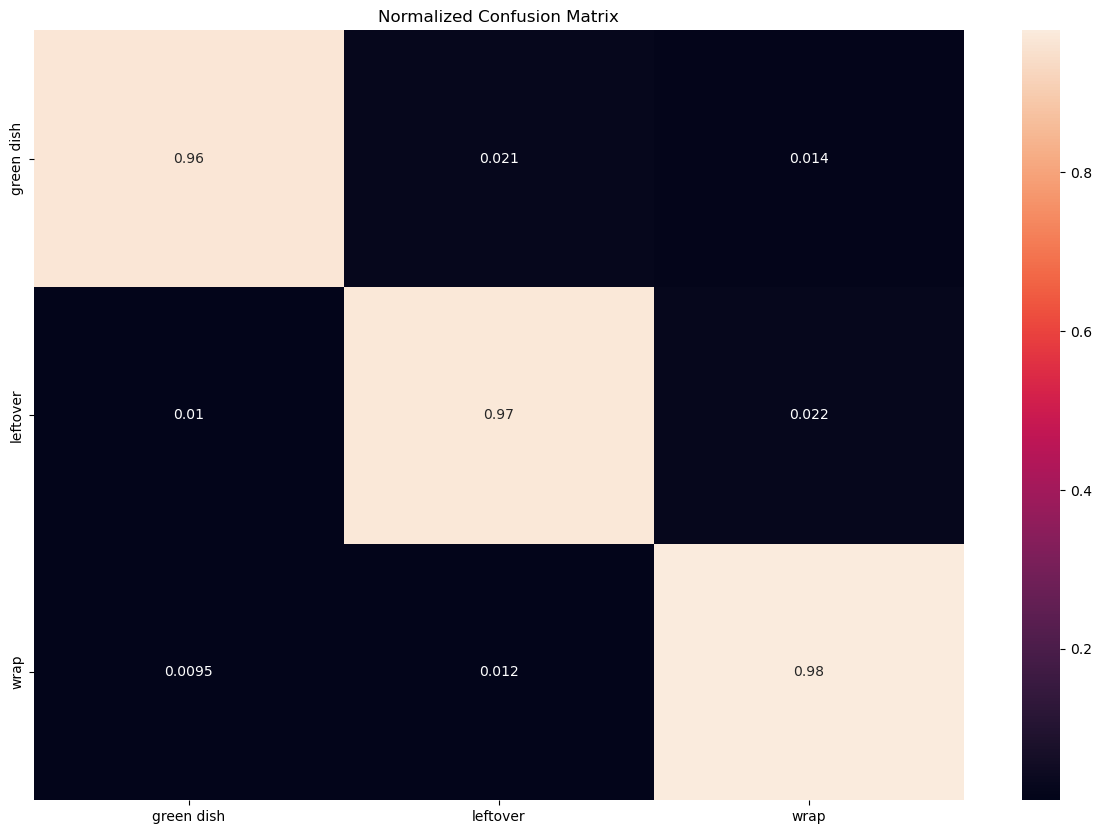

In [25]:
import seaborn as sns

test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
epoch_f1 = f1_score(test['label'], test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')
#test_matrix = confusion_matrix(test['label'], test['pred'])

plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(test['label'])), 
            yticklabels = sorted(set(test['label'])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')